# Import Packages

In [174]:
import os 
import time
from mido import MidiFile
from math import sqrt
import numpy as np
import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow.keras.layers import Dense,LayerNormalization,Add,Dropout,Embedding

# Load_data

In [22]:
seq_len = 128
gen_len = int(sqrt(seq_len))

############## preprocessing ################

paths = []
songs = []

In [23]:
# walk through every file in target folder including itself
# edit your own data path
for r,d,f in os.walk('./maestro/data/2004'):
    '''
    r: route
    d: folder in this folder
    f: file in this folder
    '''

    # if the file is mid file then append its path to paths[]
    for file in f:
        if '.mid' in file:
            paths.append(os.path.join(r,file))

In [24]:
# for each path in the array, create a Mido object and append it to songs
for path in paths:
    mid = MidiFile(path,type=1)
    songs.append(mid)

In [18]:
# 只要五首曲測試即可
songs = songs[:5]

In [25]:
songs

[<midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi' type 1, 2 tracks, 29518 messages>,
 <midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi' type 1, 2 tracks, 3903 messages>,
 <midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.midi' type 1, 2 tracks, 7775 messages>,
 <midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.midi' type 1, 2 tracks, 19019 messages>,
 <midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.midi' type 1, 2 tracks, 56556 messages>,
 <midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav.midi' type 1, 2 tracks, 14737 messages>,
 <midi file './maestro/data/2004\\MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_M

In [7]:
def calculate_note_time(song):
    notes = [] 
    calcul_time = 0
    
    for msg in song:
        if not msg.is_meta:
            if msg.type =='control_change':
                calcul_time += msg.time
            elif msg.type == 'note_on':
                if calcul_time > 0: 
            
                    notes.append([msg.note,msg.time+calcul_time])
                    calcul_time = 0
                else:
                    notes.append([msg.note,msg.time])

    return notes

In [197]:
sequences = [calculate_note_time(song) for song in songs]
sequences

[[[71, 1.0927083333333332],
  [71, 0.09687499999999999],
  [55, 0.08958333333333332],
  [71, 0.009375],
  [59, 0.175],
  [55, 0.03333333333333333],
  [59, 0.134375],
  [62, 0.0020833333333333333],
  [62, 0.11979166666666667],
  [72, 0.03333333333333333],
  [71, 0.007291666666666667],
  [67, 0.009375],
  [72, 0.025],
  [57, 0.15520833333333334],
  [74, 0],
  [67, 0.016666666666666666],
  [72, 0.0375],
  [74, 0.06041666666666667],
  [74, 0],
  [72, 0.008333333333333333],
  [72, 0.042708333333333334],
  [67, 0.022916666666666665],
  [74, 0.010416666666666666],
  [67, 0.09791666666666667],
  [66, 0.04791666666666666],
  [66, 0.18125],
  [72, 0.010416666666666666],
  [57, 0.003125],
  [71, 0],
  [64, 0.035416666666666666],
  [71, 0.03125],
  [72, 0.0010416666666666667],
  [72, 0.08333333333333333],
  [74, 0.005208333333333333],
  [59, 0.03333333333333333],
  [64, 0.051041666666666666],
  [62, 0.12395833333333334],
  [66, 0.19270833333333334],
  [62, 0.03333333333333333],
  [67, 0.1364583333

In [198]:
# 所有song 以四分音符為一拍，四拍為一小節，tempo為500000(0.5秒)，一小節為2秒，取兩小節(4秒)為一個set
# 取128為 max sequence length
time_of_set = 4
max_sequence_length = 128

In [98]:
def song_batch(notes):
    
    dataset = []
    chunk = []
    t_time = 0

    for n in notes:
    
        chunk.append((n[0],n[1]))
        t_time += n[1]
        if t_time >= time_of_set: # 假設time也是代表秒
            if len(chunk)<= max_sequence_length:
                dataset.append(chunk)
            
            t_time = 0
            chunk = []
    
    return dataset

In [199]:
sequences  = [song_batch(notes) for notes in sequences]

In [88]:
for i in sequences:
    for j in i:
        print(len(j))

52
67
70
72
68
67
85
72
46
60
73
72
73
64
71
85
75
63
50
69
70
67
54
49
70
68
63
31
70
68
64
63
54
56
73
68
62
14
90
115
105
106
110
89
112
114
103
108
102
96
114
112
125
110
88
109
115
120
100
40
30
36
24
33
33
18
34
46
42
39
19
28
34
30
35
33
17
39
42
39
45
20
26
30
30
37
34
19
32
43
30
43
55
36
41
44
50
69
23
26
34
36
43
34
19
42
39
32
41
57
36
49
42
43
58
27
15
70
99
86
79
89
101
74
85
93
101
81
82
84
94
109
62
98
101
84
100
99
75
88
82
83
92
91
75
88
96
78
95
111
89
19
9
25
27
51
28
54
53
37
15
13
27
44
41
48
54
52
21
14
24
38
38
33
42
50
30
13
11
24
39
35
41
39
52
27
7
28
63
99
121
97
105
116
99
106
105
76
73
103
106
103
95
116
99
105
122
64
77
97
98
121
113
112
117
114
104
104
109
127
78
65
102
95
108
122
108
114
119
101
108
110
115
84
21
30
29
29
57
42
27
30
24
40
68
46
64
56
48
34
20
14
20
26
33
28
29
20
14
17
41
45
41
49
38
42
41
37
45
34
39
32
52
57
52
58
43
48
51
56
60
51
46
46
37
37
19
23
44
40
39
45
43
26
20
11
54
103
91
99
88
91
102
110
93
111
104
82
101
62
116
112
98
11

86
104
96
125
109
119
114
106
110
115
105
97
5
9
7
23
8
9
8
30
8
10
11
17
10
14
11
10
12
22
10
33
26
36
22
29
29
26
23
32
27
19
10
5
10
18
29
8
11
18
36
11
14
15
15
17
16
14
38
47
33
25
8
21
6
13
12
3
56
71
68
69
61
62
68
65
85
86
82
86
85
125
126
111
23
39
34
36
19
59
72
72
65
61
59
65
64
85
86
85
84
87
108
95
61
56
74
66
84
69
68
70
66
74
73
80
81
79
78
85
85
94
96
85
63
77
86
106
113
107
88
92
89
87
88
127
56
51
63
56
22
20
11
11
127
113
94
99
92
63
125
125
121
72
17
28
15
25
19
14
27
14
15
23
21
41
49
105
126
121
13
36
36
88
70
22
8
86
126
123
107
68
20
18
9
19
34
16
30
11
23
18
4
52
44
46
58
29
74
75
62
44
53
32
25
18
36
39
36
39
36
31
38
39
30
29
52
43
49
50
53
55
45
17
16
12
10
6
67
82
103
94
99
86
87
93
50
84
96
104
110
112
120
125
75
65
86
67
42
31
34
127
106
124
108
107
116
63
76
86
60
58
69
52
62
62
75
92
6
16
19
32
100
106
82
103
94
73
11
16
12
10
8
10
96
115
126
120
124
102
111
124
80
125
105
56
36
50
55
27
26
36
55
34
56
65
62
77
55
74
93
86
88
101
103
30
48
54
63
87
103


59
87
31
44
74
82
72
85
100
88
39
69
44
81
41
70
121
125
107
62
60
70
116
49
115
105
100
87
96
53
26
43
42
48
45
37
50
16
24
25
26
26
25
25
23
20
9
14
7
24
92
30
36
12
40
55
73
32
59
27
17
41
50
28
70
34
60
62
49
39
24
48
41
33
29
31
25
35
40
87
109
122
114
44
79
27
74
61
55
36
23
47
66
48
44
34
55
19
44
36
21
24
24
16
6
14
19
14
22
7
1
126
97
95
125
127
118
92
91
107
76
58
101
67
112
95
41
60
90
92
122
118
116
79
120
128
83
125
117
116
102
122
98
113
39
52
64
44
39
51
47
45
30
43
31
39
41
30
48
66
56
38
27
48
72
97
125
101
128
117
91
21
32
48
80
91
115
105
59
126
8
48
42
43
47
30
42
58
46
38
33
38
29
31
25
27
16
65
94
98
101
126
104
128
112
97
80
74
98
102
127
115
111
99
105
99
97
98
90
101
125
105
121
113
117
94
90
101
27
31
14
51
38
63
66
50
54
61
83
66
48
46
84
55
52
69
67
68
73
83
50
53
55
71
78
65
8
7
15
26
35
22
33
29
18
20
38
29
33
41
37
28
32
32
89
116
117
119
65
80
101
107
125
120
84
24
80
34
33
31
35
100
86
75
61
44
125
116
111
93
69
82
97
112
116
74
26
115
109
110
32
12
12


17
28
29
27
20
14
28
16
24
24
20
20
32
30
29
9
18
28
22
26
29
26
27
15
23
23
20
20
6
5
51
57
63
54
53
67
47
71
75
69
68
82
52
53
56
61
43
61
47
34
50
60
77
55
55
55
56
61
77
74
57
79
57
55
59
54
55
44
8
24
23
30
22
31
32
22
21
30
36
38
36
14
11
26
37
36
23
26
22
35
30
26
22
32
24
38
31
27
10
14
34
30
32
18
24
28
34
25
38
32
30
20
27
28
26
22
18
18
24
12
103
83
85
91
83
76
121
97
79
95
85
80
118
87
62
56
60
59
64
72
63
60
68
71
57
40
128
106
80
102
88
76
88
35
11
82
48
73
78
90
102
47
78
83
90
98
93
98
58
90
94
84
66
100
108
100
103
93
93
94
99
99
90
112
80
94
93
88
22
127
81
107
96
104
105
101
95
94
21
70
66
76
81
97
102
96
125
106
96
78
85
113
117
112
86
15
84
81
95
102
87
91
65
87
92
76
117
97
105
92
97
92
99
94
99
89
111
83
95
89
80
71
123
122
81
98
105
95
101
96
32
63
9
66
11
77
62
84
20
51
40
30
86
29
73
44
53
104
23
32
60
76
76
48
59
93
100
52
32
78
31
81
31
56
48
57
80
74
75
79
80
89
74
87
84
75
77
72
63
78
99
90
94
92
93
90
86
80
67
84
39
40
40
40
68
58
73
92
40
39
44
35
29
71


In [4]:
note_cate = [str(i) for i in range(128)] + ['_','<START>','<END>']
note_to_indx = dict([(k,i) for i,k in enumerate(note_cate)])
indx_to_note = dict([(i,k) for i,k in enumerate(note_cate)])

In [200]:
# 取256為 max sequence length , 將4秒平分128等分，每秒有 16個note點 
delta =time_of_set /max_sequence_length 
delta

0.03125

In [204]:
dataset = []

In [205]:
for song in sequences:
    for seq in song:
        dataset.append(seq)

In [206]:
dataset[0]

[(71, 1.0927083333333332),
 (71, 0.09687499999999999),
 (55, 0.08958333333333332),
 (71, 0.009375),
 (59, 0.175),
 (55, 0.03333333333333333),
 (59, 0.134375),
 (62, 0.0020833333333333333),
 (62, 0.11979166666666667),
 (72, 0.03333333333333333),
 (71, 0.007291666666666667),
 (67, 0.009375),
 (72, 0.025),
 (57, 0.15520833333333334),
 (74, 0),
 (67, 0.016666666666666666),
 (72, 0.0375),
 (74, 0.06041666666666667),
 (74, 0),
 (72, 0.008333333333333333),
 (72, 0.042708333333333334),
 (67, 0.022916666666666665),
 (74, 0.010416666666666666),
 (67, 0.09791666666666667),
 (66, 0.04791666666666666),
 (66, 0.18125),
 (72, 0.010416666666666666),
 (57, 0.003125),
 (71, 0),
 (64, 0.035416666666666666),
 (71, 0.03125),
 (72, 0.0010416666666666667),
 (72, 0.08333333333333333),
 (74, 0.005208333333333333),
 (59, 0.03333333333333333),
 (64, 0.051041666666666666),
 (62, 0.12395833333333334),
 (66, 0.19270833333333334),
 (62, 0.03333333333333333),
 (67, 0.13645833333333332),
 (66, 0.022916666666666665),
 

In [185]:
f = tf.Variable((dataset))

ResourceExhaustedError: OOM when allocating tensor with shape[1040] and type int8 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: 1044

In [186]:
len(dataset)

16564

In [188]:
dataset[0]

[<tf.Tensor: shape=(131,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)>,
 <tf.Tensor: shape=(131,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [67]:
# encoder 的 embedding 就能把向量變成 三維的陣列,不需要做one-hot, 因此使用dataset中各note序列(需要轉成二維np.array(1,n,n))

In [156]:
# 轉one-hot
onehot_data = [tf.one_hot(i,seq_len) for i in dataset]
onehot_data[0]


KeyboardInterrupt



In [31]:
# 還原的方法
tf.argmax(onehot_data[0],axis=1)

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([71, 71, 55, 71, 59, 55, 59, 62, 62, 72, 71, 67, 72, 57, 74, 67, 72,
       74, 74, 72, 72, 67, 74, 67, 66, 66, 72, 57, 71, 64, 71, 72, 72, 74,
       59, 64, 62, 66, 62, 67, 66, 59, 74, 71, 71, 74, 78, 74, 59, 59, 79,
       78, 76, 60, 79, 60, 76, 79, 74, 79, 59, 74, 79, 59, 72, 79, 57, 72,
       71, 71, 72, 66, 57, 67, 81, 72, 66, 72, 55, 81, 72, 71, 71, 69, 59,
       59, 69, 67, 55, 71, 62, 67, 54, 62, 54, 67, 52, 67, 52, 50, 71, 50,
       49, 64, 76, 64, 76, 69, 52, 52, 69, 76, 57, 67, 76, 49, 67, 66, 66,
       49, 67, 49, 76, 67, 67, 76, 50, 66], dtype=int64)>

## Data Shape


# Blocks

d_model 是seq長度，不是model

一般會讓 dff 這個參數大於 d_model，讓 FFN 從輸入的 d_model 維度裡頭學些有用的資訊。在論文中 d_model 為 512，dff 為 2048。兩個都是可以調整的參數。

## Positional Encoding

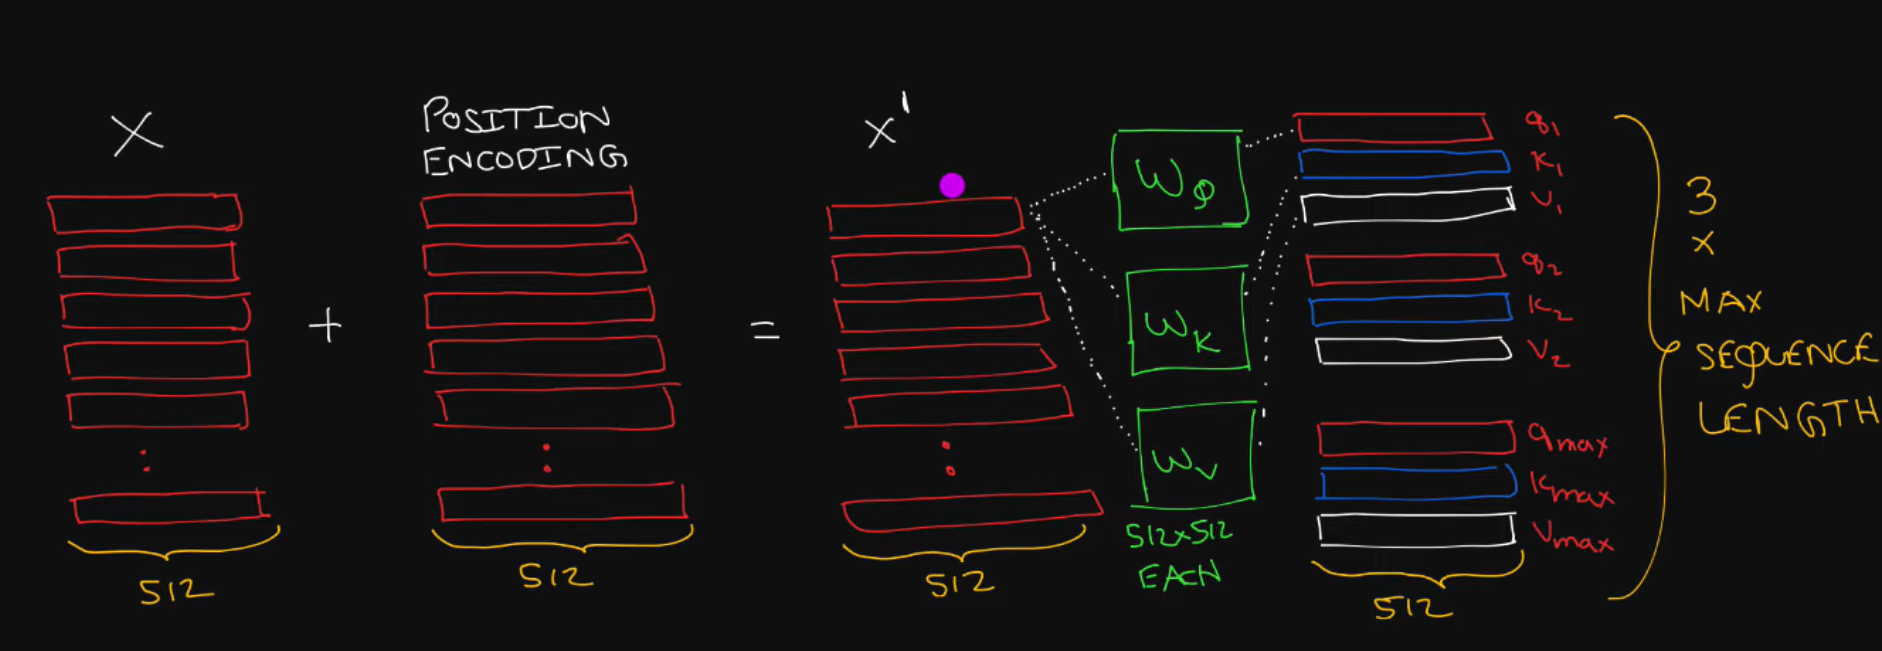

Positional Encoding 公式:
$$ PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}}) $$
$$ PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}}) $$

$i$ = dinension index
$d_{model}$ = Embedding Length
$pos$ = Position of word in sequence

WHY?
1. Periodicity(週期性)
2. Constrained Values(約束) Values ,較不會受到距離太遠位置的word影響
3. Easy to extrapolate(推論) for long sequences

簡單來說, 即是使序列資料擁有位置資訊

#### practice

In [290]:
max_sequence_length = 10
d_model = 6

even
$$ PE_{(pos,2i)} = \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) $$

odd
$$ PE_{(pos,2i+1)} = \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

we can rewrite these as:

even
$$ PE_{(pos,i)} = \sin(\frac{pos}{10000^{\frac{i}{d_{model}}}}) $$

odd
$$ PE_{(pos,i)} = \cos(\frac{pos}{10000^{\frac{i-1}{d_{model}}}})$$

In [291]:
even_i = tf.range(start=0,limit=d_model,delta=2)
even_i

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 2, 4])>

In [292]:
even_denominator = tf.pow(10000,even_i/d_model)
even_denominator

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([  1.        ,  21.5443469 , 464.15888336])>

In [293]:
odd_i = tf.range(start=1,limit=d_model,delta=2)
odd_i

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 3, 5])>

In [294]:
odd_denominator = tf.pow(10000,(odd_i-1)/d_model)
odd_denominator

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([  1.        ,  21.5443469 , 464.15888336])>

`even_denominator` and `odd_denominator` are the same. So we can just do one of these actions and call the resulting variable denominator

In [295]:
denominator = even_denominator

In [299]:
# determine every single position for the sequence
position = tf.reshape(tf.range(max_sequence_length,dtype=tf.float64),[max_sequence_length,1])

In [300]:
position

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.],
       [9.]])>

In [301]:
# devide every position
even_PE = tf.math.sin(position/denominator)
odd_PE = tf.math.cos(position/denominator)

In [302]:
even_PE

<tf.Tensor: shape=(10, 3), dtype=float64, numpy=
array([[ 0.        ,  0.        ,  0.        ],
       [ 0.84147098,  0.04639922,  0.00215443],
       [ 0.90929743,  0.0926985 ,  0.00430886],
       [ 0.14112001,  0.1387981 ,  0.00646326],
       [-0.7568025 ,  0.18459872,  0.00861763],
       [-0.95892427,  0.23000171,  0.01077197],
       [-0.2794155 ,  0.27490927,  0.01292625],
       [ 0.6569866 ,  0.31922465,  0.01508047],
       [ 0.98935825,  0.36285241,  0.01723462],
       [ 0.41211849,  0.40569857,  0.0193887 ]])>

In [303]:
odd_PE

<tf.Tensor: shape=(10, 3), dtype=float64, numpy=
array([[ 1.        ,  1.        ,  1.        ],
       [ 0.54030231,  0.99892298,  0.99999768],
       [-0.41614684,  0.99569422,  0.99999072],
       [-0.9899925 ,  0.9903207 ,  0.99997911],
       [-0.65364362,  0.98281398,  0.99996287],
       [ 0.28366219,  0.97319022,  0.99994198],
       [ 0.96017029,  0.96147017,  0.99991645],
       [ 0.75390225,  0.94767907,  0.99988628],
       [-0.14550003,  0.93184662,  0.99985147],
       [-0.91113026,  0.91400693,  0.99981202]])>

In [304]:
# merge even_PE & odd_PE
stacked = tf.stack([even_PE,odd_PE],axis=2)
stacked.shape

TensorShape([10, 3, 2])

In [309]:
# flatten the stacked so index 0 would be first of even_PE ,and the second
# would be first of odd_PE... and so on
PE = tf.reshape(stacked, [-1])
PE

<tf.Tensor: shape=(60,), dtype=float64, numpy=
array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.84147098,  0.54030231,  0.04639922,  0.99892298,
        0.00215443,  0.99999768,  0.90929743, -0.41614684,  0.0926985 ,
        0.99569422,  0.00430886,  0.99999072,  0.14112001, -0.9899925 ,
        0.1387981 ,  0.9903207 ,  0.00646326,  0.99997911, -0.7568025 ,
       -0.65364362,  0.18459872,  0.98281398,  0.00861763,  0.99996287,
       -0.95892427,  0.28366219,  0.23000171,  0.97319022,  0.01077197,
        0.99994198, -0.2794155 ,  0.96017029,  0.27490927,  0.96147017,
        0.01292625,  0.99991645,  0.6569866 ,  0.75390225,  0.31922465,
        0.94767907,  0.01508047,  0.99988628,  0.98935825, -0.14550003,
        0.36285241,  0.93184662,  0.01723462,  0.99985147,  0.41211849,
       -0.91113026,  0.40569857,  0.91400693,  0.0193887 ,  0.99981202])>

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self,d_model,max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model
        
    def call(self):
        even_i = tf.range(start=0,limit=self.d_model,delta=2)
        denominator = tf.pow(10000,even_i/self.d_model)
        position = tf.reshape(tf.range(self.max_sequence_length,dtype=tf.float64),[self.max_sequence_length,1])
        even_PE = tf.math.sin(position/denominator)
        odd_PE = tf.math.cos(position/denominator)
        stacked = tf.stack([even_PE,odd_PE],axis=2)
        PE = tf.reshape(stacked, [-1])
        return PE

In [311]:
pe = PositionalEncoding(d_model=6,max_sequence_length=10)
pe.call()

<tf.Tensor: shape=(60,), dtype=float64, numpy=
array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.84147098,  0.54030231,  0.04639922,  0.99892298,
        0.00215443,  0.99999768,  0.90929743, -0.41614684,  0.0926985 ,
        0.99569422,  0.00430886,  0.99999072,  0.14112001, -0.9899925 ,
        0.1387981 ,  0.9903207 ,  0.00646326,  0.99997911, -0.7568025 ,
       -0.65364362,  0.18459872,  0.98281398,  0.00861763,  0.99996287,
       -0.95892427,  0.28366219,  0.23000171,  0.97319022,  0.01077197,
        0.99994198, -0.2794155 ,  0.96017029,  0.27490927,  0.96147017,
        0.01292625,  0.99991645,  0.6569866 ,  0.75390225,  0.31922465,
        0.94767907,  0.01508047,  0.99988628,  0.98935825, -0.14550003,
        0.36285241,  0.93184662,  0.01723462,  0.99985147,  0.41211849,
       -0.91113026,  0.40569857,  0.91400693,  0.0193887 ,  0.99981202])>

## self-Attention

### single self attention head
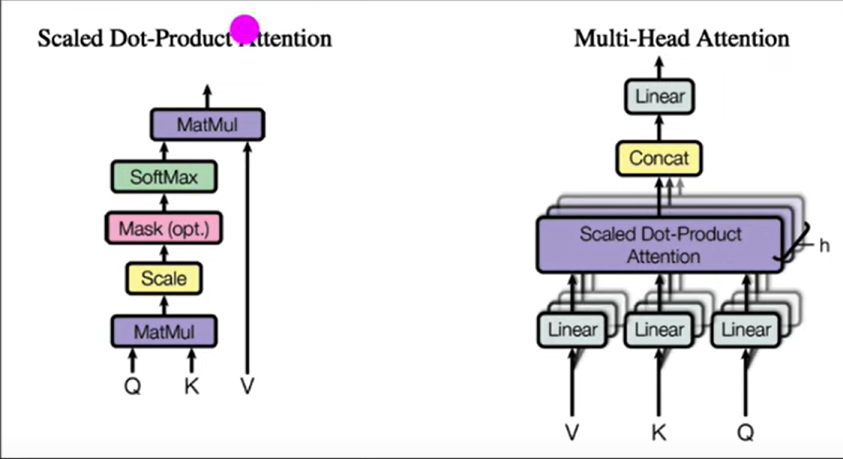

**Q**: What I am looking for [$ Sequence Length \times d_k$]

**K**: What I can offer [$Sequence Length \times d_k$]

**V**: What I actually offer [$Sequence Length \times d_v$]

In [172]:
# practice
import math
# L is the Length of Sequence
# Since the input is "My name is Jason", so L is going to be 4 
L, d_k, d_v = 4,8,8
q = np.random.randn(L,d_k)
k = np.random.randn(L,d_k)
v = np.random.randn(L,d_v)

In [174]:
print('Q\n',q) # My(0) name(1) is(2) Jason(3)
print('K\n',k)
print('V\n',v)

Q
 [[-0.01878515 -0.71403973 -1.37183651 -0.20184429  0.71801106  0.75054019
  -1.27920113  0.26656859]
 [ 0.13889694  2.29034871 -0.97578219 -0.12727912  0.48190875  0.47130122
   1.78283064  0.58360262]
 [-1.37816566  0.35454773 -2.43973624 -1.89917618  0.75527605 -0.62702121
   0.3921621  -1.91005136]
 [ 0.38470147 -1.4902425  -0.12815998  1.20893371  0.36681943  0.80777857
  -0.32711129  1.397296  ]]
K
 [[ 1.32400492  0.17074879  0.5117483  -2.06620438  0.51527634  1.44825524
  -0.34746531  0.21913545]
 [-1.06119346 -0.32724736 -0.65479881 -0.08251239  0.43099463 -1.02535703
   0.07923258 -0.12057869]
 [ 1.09357168 -0.43615452 -0.48761991 -0.25144883  0.19579518  1.78459753
   1.62625615  0.10058404]
 [ 0.89306092 -0.30988943  2.09333033  1.23886331 -0.18732021 -0.20505706
  -0.66677174  0.4130773 ]]
V
 [[ 0.59143369 -1.72717321 -0.32087643 -0.76590536 -0.3328891   1.32044836
  -0.26270224  1.6554204 ]
 [-1.05397509  2.25854328  0.08815315  1.2322031  -2.80345441 -0.34657486
  -0.6

$$ self attention = softmax(\frac{QK^T}{\sqrt{d_k}}+M)V $$

In [175]:
np.matmul(q,k.T)

array([[ 1.52806403,  0.57492421,  0.43707617, -2.24262035],
       [ 0.77790115, -0.45212767,  3.55424163, -3.92061031],
       [-0.16233784,  4.33054156, -0.5200167 , -9.86403485],
       [-0.5298604 , -0.800964  ,  1.95114308,  2.59574112]])

In [177]:
q.var(),k.var(),np.matmul(q,k.T).var()

(1.1992133007622578, 0.8046373467771912, 10.25285666231183)

因為需要降低 QK 的matmul 的var, 所以需要除以根號$d_k$

In [178]:
scaled = np.matmul(q,k.T)/math.sqrt(d_k)
q.var(),k.var(),scaled.var()

(1.1992133007622578, 0.8046373467771912, 1.2816070827889785)

In [179]:
scaled

array([[ 0.54025222,  0.2032664 ,  0.15452976, -0.79288603],
       [ 0.27502959, -0.15985127,  1.25661418, -1.38614507],
       [-0.05739509,  1.53107765, -0.18385367, -3.48746297],
       [-0.18733394, -0.28318354,  0.68983325,  0.91773307]])

### Masking

* This is to ensure words don't get context(前後關係) from words generated in the future

* Not required in the eocoder, but required in the decoders

In [180]:
# 預期mask 要做到這個樣子
# 第一項只有第一項的input的資訊，第二項有第一項和第二項input的資訊..以此類推
mask = np.tril(np.ones((L,L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [181]:
mask[mask==0] = -np.infty
mask[mask==1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

如此一來和scaled相加之後`-inf`的位置就還是會維持`-inf`，代表被mask

In [182]:
scaled + mask

array([[ 0.54025222,        -inf,        -inf,        -inf],
       [ 0.27502959, -0.15985127,        -inf,        -inf],
       [-0.05739509,  1.53107765, -0.18385367,        -inf],
       [-0.18733394, -0.28318354,  0.68983325,  0.91773307]])

### Softmax

$$ softmax = \frac{e^{x_i}}{\sum_j e^x_j}$$

In [183]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x),axis=1)).T

In [196]:
#若with or without mask, attention 後的每一列和等於1,因為這是機率分配
# attention = softmax(scaled)
attention = softmax(scaled+mask)

In [197]:
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.60703857, 0.39296143, 0.        , 0.        ],
       [0.14754755, 0.72243197, 0.13002048, 0.        ],
       [0.13638644, 0.12392081, 0.32788388, 0.41180887]])

In [198]:
#如果有mask, new_v 和 v 的第一項維持一樣
new_v = np.matmul(attention,v)
new_v

array([[ 0.59143369, -1.72717321, -0.32087643, -0.76590536, -0.3328891 ,
         1.32044836, -0.26270224,  1.6554204 ],
       [-0.0551485 , -0.16094036, -0.16014358,  0.0192742 , -1.30372598,
         0.66537253, -0.39909123,  0.33465947],
       [-0.65918987,  1.43773171,  0.11178827,  0.70290074, -2.04548495,
        -0.05345828, -0.63005222, -1.24298327],
       [ 0.23927099, -0.22892469, -0.27805562, -0.57266545, -0.71810493,
         0.61519195, -0.80911312, -0.74617957]])

In [199]:
v

array([[ 0.59143369, -1.72717321, -0.32087643, -0.76590536, -0.3328891 ,
         1.32044836, -0.26270224,  1.6554204 ],
       [-1.05397509,  2.25854328,  0.08815315,  1.2322031 , -2.80345441,
        -0.34657486, -0.60978208, -1.70562427],
       [ 0.11514219,  0.46860326,  0.73410089, -0.57125403,  0.2225582 ,
         0.01607096, -1.15954875, -1.96152945],
       [ 0.6106319 , -1.03662082, -1.17995585, -1.05290826, -0.96712409,
         1.14805474, -0.77104231, -0.28518142]])

### scaled_dot_product_attention

In [200]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x),axis=1)).T

def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.shape[-1]
    scaled  = np.matmul(q,k.T) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask
    attention = softmax(scaled)
    out = np.matmul(attention,v)
    return out,attention

In [203]:
values,attention = scaled_dot_product_attention(q,k,v,mask=None)

In [204]:
print('Q\n',q)
print('K\n',k)
print('V\n',v)
print('New V\n',values)
print('Attention\n',attention)

Q
 [[-0.01878515 -0.71403973 -1.37183651 -0.20184429  0.71801106  0.75054019
  -1.27920113  0.26656859]
 [ 0.13889694  2.29034871 -0.97578219 -0.12727912  0.48190875  0.47130122
   1.78283064  0.58360262]
 [-1.37816566  0.35454773 -2.43973624 -1.89917618  0.75527605 -0.62702121
   0.3921621  -1.91005136]
 [ 0.38470147 -1.4902425  -0.12815998  1.20893371  0.36681943  0.80777857
  -0.32711129  1.397296  ]]
K
 [[ 1.32400492  0.17074879  0.5117483  -2.06620438  0.51527634  1.44825524
  -0.34746531  0.21913545]
 [-1.06119346 -0.32724736 -0.65479881 -0.08251239  0.43099463 -1.02535703
   0.07923258 -0.12057869]
 [ 1.09357168 -0.43615452 -0.48761991 -0.25144883  0.19579518  1.78459753
   1.62625615  0.10058404]
 [ 0.89306092 -0.30988943  2.09333033  1.23886331 -0.18732021 -0.20505706
  -0.66677174  0.4130773 ]]
V
 [[ 0.59143369 -1.72717321 -0.32087643 -0.76590536 -0.3328891   1.32044836
  -0.26270224  1.6554204 ]
 [-1.05397509  2.25854328  0.08815315  1.2322031  -2.80345441 -0.34657486
  -0.6

### Multi Head Attention practice

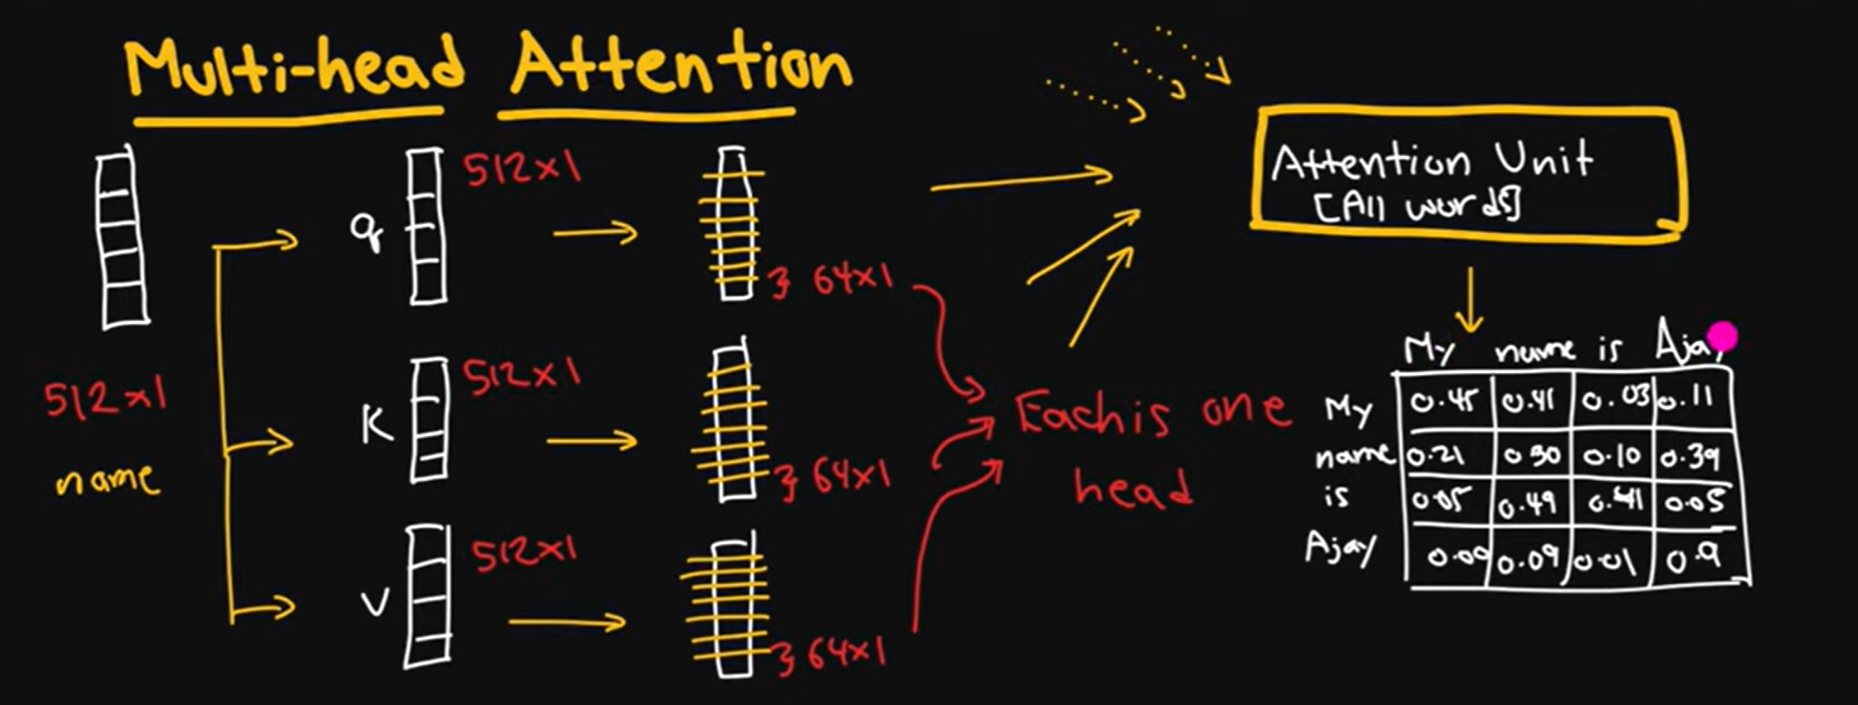

In [206]:
sequence_length = 4 # e.g. 'My name is Jason'
batch_size = 1 # 平行處理的量
input_dim = 512 # 每個字輸入進attention 的維度
d_model = 512 # output of the attention unit for every single word
x = tf.random.normal([batch_size,sequence_length,input_dim])

In [207]:
x.shape

TensorShape([1, 4, 512])

In [215]:
# map the input from input_dim to 3 times of model dimension
qkv_layer = Dense(3*d_model,input_shape=(input_dim,))
# create the query vector(q),key vector(k),value vector(v)

In [216]:
qkv = qkv_layer(x)

In [217]:
qkv.shape

TensorShape([1, 4, 1536])

In [229]:
num_heads = 8 # 8 attention heads
head_dim = d_model // num_heads
qkv = tf.reshape(qkv,[batch_size,sequence_length,num_heads,3*head_dim])
# 3 表示 q,k,v

In [230]:
qkv.shape

TensorShape([1, 4, 8, 192])

In [231]:
qkv = tf.transpose(qkv,perm=[0,2,1,3]) #[batch_size,num_heads,sequence_length,3*head_dim]
# 調換 第2維和第3 維使得能更easy 平行處理

In [232]:
qkv.shape

TensorShape([1, 8, 4, 192])

In [260]:
# 將最後一維拆分開來以將q,k,v,分開
q,k,v = tf.split(qkv,3,axis=3)
q.shape,k.shape,v.shape

(TensorShape([1, 8, 4, 64]),
 TensorShape([1, 8, 4, 64]),
 TensorShape([1, 8, 4, 64]))

跟single attention不同的是 在做 $k.T$的轉置動作時，因為現在k 有4個維度而非2個維度, 所以轉置時需要特別指定要轉換的維度(最後兩個維度)

In [240]:
# do the attention part
d_k = q.shape[-1]
# 獲取 tensor 的維度數
num_dimensions = tf.rank(k)
perm = tf.concat([tf.range(num_dimensions - 2), tf.range(num_dimensions - 1, num_dimensions - 3, -1)], axis=0)

scaled = tf.matmul(q,tf.transpose(k,perm=perm))/math.sqrt(d_k)
scaled.shape

TensorShape([1, 8, 4, 4])

In [250]:
# masking for decoder
mask = tf.fill(scaled.shape,float('-inf'))
mask = tf.experimental.numpy.triu(mask,k=1) # k=1 對角線右邊一個
mask[0][1] # display mask for a single head

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]], dtype=float32)>

In [253]:
(scaled+mask)[0][0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-0.31609458,        -inf,        -inf,        -inf],
       [ 0.15399346,  0.16531506,        -inf,        -inf],
       [-0.27120247,  0.7176732 ,  0.00148216,        -inf],
       [ 0.31226778,  0.7220832 ,  0.9228094 ,  0.25391725]],
      dtype=float32)>

In [254]:
scaled += mask

In [255]:
# 加上mask(or not) 後做softmax計算
attention = tf.nn.softmax(scaled,axis=-1)

In [256]:
attention.shape

TensorShape([1, 8, 4, 4])

In [257]:
attention[0][0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1.        , 0.        , 0.        , 0.        ],
       [0.4971696 , 0.5028304 , 0.        , 0.        ],
       [0.19993219, 0.53745973, 0.26260808, 0.        ],
       [0.18898992, 0.2847208 , 0.34801143, 0.17827784]], dtype=float32)>

In [258]:
# generate the new value vectors
values = tf.matmul(attention,v)
values.shape

TensorShape([1, 8, 4, 64])

In [259]:
# 因為在計算multihead attention 都是用tensor在記錄，所以需要重新設計過scaled_dot_product
def scaled_dot_product(q,k,v,mask=None):
    d_k = q.shape[-1]
    # 計算scaled
    num_dimensions = tf.rank(k)# 獲取 tensor 的維度數
    perm = tf.concat([tf.range(num_dimensions - 2), tf.range(num_dimensions - 1, num_dimensions - 3, -1)], axis=0)
    scaled = tf.matmul(q,tf.transpose(k,perm=perm))/math.sqrt(d_k)
    
    if mask is not None:
        scaled += mask
    attention = tf.nn.softmax(scaled,axis=-1)
    values = tf.matmul(attention,v)
    return values,attention

In [266]:
# 沒有mask (for Encoder)
# values,attention = scaled_dot_product(q,k,v)
# 有mask (for Decoer)
values,attention = scaled_dot_product(q,k,v,mask)

In [267]:
attention.shape

TensorShape([1, 8, 4, 4])

In [268]:
attention[0][0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1.        , 0.        , 0.        , 0.        ],
       [0.4971696 , 0.5028304 , 0.        , 0.        ],
       [0.19993219, 0.53745973, 0.26260808, 0.        ],
       [0.18898992, 0.2847208 , 0.34801143, 0.17827784]], dtype=float32)>

In [270]:
values.shape

TensorShape([1, 8, 4, 64])

In [271]:
# 最後reshape回要輸出的dim數,這代表把所有head數全部結合在一起
# 假設你的values shape最後是[1,8,4,64] ，結合在一起之後會變[1,4,512](512=8*64)
values = tf.reshape(values,[batch_size,sequence_length,num_heads*head_dim])
values.shape

TensorShape([1, 4, 512])

In [273]:
# 做一次FeedFoward layer
linear_layer = Dense(d_model,input_shape=(d_model,))

In [274]:
# 並不會改變tensor的維度
out = linear_layer(values)

In [275]:
out.shape

TensorShape([1, 4, 512])

## Multihead Attention (function)

In [4]:
def scaled_dot_product(q,k,v,mask=None):
    # q,k,b = 30 x 8 x 128 x 64
    d_k = q.shape[-1] # 64
    # 計算scaled
    num_dimensions = tf.rank(k)# 獲取 tensor 的維度數 
    perm = tf.concat([tf.range(num_dimensions - 2), tf.range(num_dimensions - 1, num_dimensions - 3, -1)], axis=0)
    scaled = tf.matmul(q,tf.transpose(k,perm=perm))/math.sqrt(d_k) # 30 x 8 x 128 x 128
    
    if mask:
        scaled += mask # 30 x 8 x 128 x 128
    attention = tf.nn.softmax(scaled,axis=-1) # 30 x 8 x 128 x 128
    values = tf.matmul(attention,v) # 30 x 8 x 200 x 64
    return values,attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_hes = num_heads # 8
        self.head_dim = d_model // num_heads # e.g. 512 // 8 = 64
        self.qkv_layer = Dense(3*d_model,input_shape=(d_model,)) # 512 x 1536
        self.linear_layer = Dense(d_model,input_shape=(d_model,)) # 512 x 512
        
    
    def call(self,x,mask=None): # mask 另外弄
        
        batch_size,sequence_length,d_model = x.shape # 30 x 128 x 512
#         print(f"x shape: {x.shape}")
        qkv = self.qkv_layer(x) # 30 x 128 x 1536
#         print(f"qkv shape: {qkv.shape}")
        qkv = tf.reshape(qkv,[batch_size,sequence_length,num_heads,3*head_dim]) # 30 x 128 x 8 x 192(64*3)
#         print(f"qkv shape: {qkv.shape}")
        qkv = tf.transpose(qkv,perm=[0,2,1,3]) # 30 x 8 x 128 x 192
#         print(f"qkv shape: {qkv.shape}")
        q,k,v, = tf.split(qkv,3,axis=-1) # each are 30 x 8 x 128 x 64
#         print(f"q shape: {q.shape} || k shape: {k.shape} || v shape: {v.shape}")
        values,attention = scaled_dot_product(q,k,v,mask) # attention = 30 x 8 x 128 x 128, values = 30 x 8 x 128 x 64
#         print(f"values shape: {values.shape} || attention shape: {attention.shape}")
        values = tf.reshape(values,[batch_size,sequence_length,num_heads*head_dim]) # 30 x 128 x 512
#         print(f"values shape: {values.shape}")
        out = self.linear_layer(values)
#         print(f"out shape: {out.shape}")
        return out

## Multihead Cross Attention (function)

In [5]:
class MultiHeadCrossAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_hes = num_heads # 8
        self.head_dim = d_model // num_heads # e.g. 512 // 8 = 64
        self.kv_layer = Dense(2*d_model,input_shape=(d_model,)) # 512 x 1024
        self.q_layer = Dense(d_model,input_shape=(d_model,)) # 512 x 512
        self.linear_layer = Dense(d_model,input_shape=(d_model,)) # 512 x 512
        
    
    def call(self,x,y,mask=None): # mask 另外弄
        
        batch_size,sequence_length,d_model = x.shape # 30 x 128 x 512
#         print(f"x shape: {x.shape}")
        kv = self.kv_layer(x) # 30 x 128 x 1024
#         print(f"qkv shape: {qkv.shape}")
        q =  self.q_layer(y) # 30 x 128 x 512
        kv = tf.reshape(kv,[batch_size,sequence_length,self.num_heads,2*self.head_dim]) # 30 x 128 x 8 x 128
        q = tf.reshape(q,[batch_size,sequence_length,self.num_heads,self.head_dim]) # 30 x 128 x 8 x 64
#         print(f"qkv shape: {qkv.shape}")
        kv = tf.transpose(kv,perm=[0,2,1,3]) # 30 x 8 x 128 x 128
        q = tf.transpose(q,perm=[0,2,1,3]) # 30 x 8 x 128 x 64
#         print(f"qkv shape: {qkv.shape}")
        k,v = tf.split(kv,2,axis=-1) # k: 30 x 8 x 128 x 64 v: 30 x 8 x 128 x 64
#         print(f"q shape: {q.shape} || k shape: {k.shape} || v shape: {v.shape}")
        values,attention = scaled_dot_product(q,k,v,mask) # attention = 30 x 8 x 128 x 128, values = 30 x 8 x 128 x 64
#         print(f"values shape: {values.shape} || attention shape: {attention.shape}")
        values = tf.reshape(values,[batch_size,sequence_length,d_model]) # 30 x 128 x 512
#         print(f"values shape: {values.shape}")
        out = self.linear_layer(values) # 30 x 128 x 512
#         print(f"out shape: {out.shape}")
        return out

In [289]:
# Test
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = tf.random.normal((batch_size,sequence_length,input_dim))

layer = MultiheadAttention(input_dim,d_model,num_heads)
out = layer.call(x)

x shape: (30, 5, 1024)
qkv shape: (30, 5, 1536)
qkv shape: (30, 5, 8, 192)
qkv shape: (30, 8, 5, 192)
q shape: (30, 8, 5, 64) || k shape: (30, 8, 5, 64) || v shape: (30, 8, 5, 64)
values shape: (30, 8, 5, 64) || attention shape: (30, 8, 5, 5)
values shape: (30, 5, 512)
out shape: (30, 5, 512)


## Normalization

In [38]:
# 使用Keras 的 Layer Normalization

In [322]:
norm_out = LayerNormalization(epsilon = 1e-5)

In [325]:
norm_out(inputs)

<tf.Tensor: shape=(1, 2, 3), dtype=float32, numpy=
array([[[ 0.        , -1.2238272 ,  1.2238271 ],
        [ 1.4140145 , -0.70700735, -0.70700735]]], dtype=float32)>

#### practice (build LayerNorm by hand)

In [326]:
# 可以自己定義輸出的shape

In [327]:
inputs = tf.constant([[[0.2,0.1,0.3],[0.5,0.1,0.1]]])
B,S,E = inputs.shape # B for batch during training
inputs =  tf.reshape(inputs,[S,B,E]) # 算LayerNorm前先reshape
inputs.shape

TensorShape([2, 1, 3])

In [328]:
parameter_shape = inputs.shape[-2:]
gamma = tf.Variable(tf.ones(parameter_shape))
beta = tf.Variable(tf.zeros(parameter_shape))

In [329]:
gamma.shape,beta.shape

(TensorShape([1, 3]), TensorShape([1, 3]))

In [330]:
dims = [-(i+1) for i in range(len(parameter_shape))]
dims

[-1, -2]

In [333]:
mean = tf.reduce_mean(inputs,axis=dims,keepdims=True)
mean.shape

TensorShape([2, 1, 1])

In [334]:
mean

<tf.Tensor: shape=(2, 1, 1), dtype=float32, numpy=
array([[[0.2       ]],

       [[0.23333335]]], dtype=float32)>

In [335]:
var = tf.reduce_mean(((inputs-mean)**2),axis=dims,keepdims=True)
epsilon = 1e-5 # make sure std doesn't become zero
std = tf.math.sqrt(var+epsilon)
std

<tf.Tensor: shape=(2, 1, 1), dtype=float32, numpy=
array([[[0.08171088]],

       [[0.18858834]]], dtype=float32)>

In [336]:
y = (inputs-mean)/std
y

<tf.Tensor: shape=(2, 1, 3), dtype=float32, numpy=
array([[[ 0.       , -1.2238274,  1.2238274]],

       [[ 1.4140146, -0.7070074, -0.7070074]]], dtype=float32)>

In [337]:
out = gamma * y + beta
out

<tf.Tensor: shape=(2, 1, 3), dtype=float32, numpy=
array([[[ 0.       , -1.2238274,  1.2238274]],

       [[ 1.4140146, -0.7070074, -0.7070074]]], dtype=float32)>

In [6]:
class LayerNorm(tf.keras.layers.Layer):
    def __init__(self,parameter_shape,eps=1e-5):
        super().__init__()
        self.parameter_shape = parameter_shape # [512]
        self.eps = eps
        self.gamma = tf.Variable(tf.ones(parameter_shape)) # [512]
        self.beta = tf.Variable(tf.zeros(parameter_shape)) # [512]
        
    def call(self,x): 
        # input = 30 x 200 x 512
        dims = [-(i+1) for i in range(len(self.parameter_shape))] # [-1]
        mean = tf.reduce_mean(x,axis=dims,keepdims=True) # 30 x 128 x 1
#         print(f"Mean \n ({mean.shape}): \n {mean}") 
        var = tf.reduce_mean(((x-mean)**2),axis=dims,keepdims=True) # 30 x 128 x 1
        std = tf.math.sqrt(var+self.eps) # 30 x 128 x 1
#         print(f"Standard Deviation \n ({std.shape}): \n {std}")
        y = (x - mean) / std # 30 x 128 x 512
#         print(f"y \n ({y.shape}) = \n {y}")
        out = self.gamma * y + self.beta # # 30 x 128 x 512
#         print(f"out \n ({out.shape}) = \n {out}")
        return out

In [339]:
batch_size = 3
sentence_length = 5
embedding_dim = 8
inputs = tf.random.normal([sentence_length,batch_size,embedding_dim])
print(f"input \n ({inputs.shape}) = \n {inputs}")

input 
 ((5, 3, 8)) = 
 [[[-1.4141942  -0.3709266  -1.3001901  -0.19066106 -0.5404296
   -0.32362553 -0.94286156  0.1562298 ]
  [ 0.32862204  0.29531598  1.2991618  -0.6963944   0.2811987
   -1.0772448   0.3896833   0.3268545 ]
  [-1.342053   -1.4732121   1.2742134  -1.1170117  -0.6124404
   -0.3133611  -1.9701494  -1.0047767 ]]

 [[ 1.6926132   0.1847868  -0.42982274  2.0375009   0.84725505
    1.582644    1.1161592   1.2460074 ]
  [ 0.11676026 -0.36843005  0.05671371  0.15496704  0.17507939
    3.3043933  -0.2807453   1.8826319 ]
  [ 0.45804235  0.3701378  -0.17095648  2.4423347   0.244448
   -0.07775921  0.72139436 -1.4671185 ]]

 [[ 0.99050456 -0.38293743 -0.01548758  1.7556548   0.46707186
    0.9230353  -0.1334222   0.833801  ]
  [-0.9635939  -0.4367844   0.6188443   0.6383293   0.5566845
    1.2070706  -0.09590977  0.2571612 ]
  [-0.70908064 -0.20082748  0.78606135 -0.76922524  0.6456665
    0.44605142 -0.7567301   0.5877274 ]]

 [[-0.9429782   0.15189807 -0.8012241   0.72415316

In [397]:
inputs.shape[-2:]

TensorShape([3, 8])

In [346]:
layer_norm = LayerNorm(inputs.shape[-2:])

In [347]:
out = layer_norm.call(inputs)

Mean 
 ((5, 1, 1)): 
 [[[-0.43076053]]

 [[ 0.65995985]]

 [[ 0.2604027 ]]

 [[-0.06504437]]

 [[-0.06184901]]]
Standard Deviation 
 ((5, 1, 1)): 
 [[[0.83653164]]

 [[1.0534145 ]]

 [[0.6893506 ]]

 [[0.8063377 ]]

 [[0.7733923 ]]]
y 
 ((5, 3, 8)) = 
 [[[-1.1756085e+00  7.1526214e-02 -1.0393265e+00  2.8701779e-01
   -1.3109972e-01  1.2807047e-01 -6.1217177e-01  7.0169532e-01]
  [ 9.0777510e-01  8.6796057e-01  2.0679700e+00 -3.1754190e-01
    8.5108465e-01 -7.7281505e-01  9.8076850e-01  9.0566212e-01]
  [-1.0893701e+00 -1.2461592e+00  2.0381465e+00 -8.2035291e-01
   -2.1718231e-01  1.4034069e-01 -1.8402040e+00 -6.8618590e-01]]

 [[ 9.8029160e-01 -4.5107892e-01 -1.0345241e+00  1.3076915e+00
    1.7779820e-01  8.7589848e-01  4.3306729e-01  5.5633146e-01]
  [-5.1565611e-01 -9.7624439e-01 -5.7265794e-01 -4.7938666e-01
   -4.6029410e-01  2.5103447e+00 -8.9300573e-01  1.1606752e+00]
  [-1.9167906e-01 -2.7512631e-01 -7.8878385e-01  1.6919978e+00
   -3.9444289e-01 -7.0031226e-01  5.8319408e-02

## Feed Foward Network (Fully Connected network)

In [7]:

class PositionwiseFeedForward(tf.keras.layers.Layer):
    def __init__(self,d_model,hidden,drop_prob=0.1):
        
        super(PositionwiseFeedForward,self).__init__()
        self.linear1 = Dense(hidden,input_shape=(d_model,)) # 512 x 2048
        self.linear2 = Dense(d_model,input_shape=(hidden,)) # 2048 x 512
        self.relu = tf.keras.layers.ReLU() # 
        self.dropout = Dropout(drop_prob)
        
    def call(self,x): 
        # input = 30 x 128 x 512
        x = self.linear1(x) # 30 x 128 x 2048 
#         print(f"x \n {x.shape}")
        x = self.relu(x) # 30 x 128 x 2048
#         print(f"x \n {x.shape}")
        x = self.dropout(x) # 30 x 128 x 2048
#         print(f"x \n {x.shape}")
        x = self.linear2(x) # 30 x 128 x 512
#         print(f"x \n {x.shape}")
        return x

# Word(Note) Embedding 

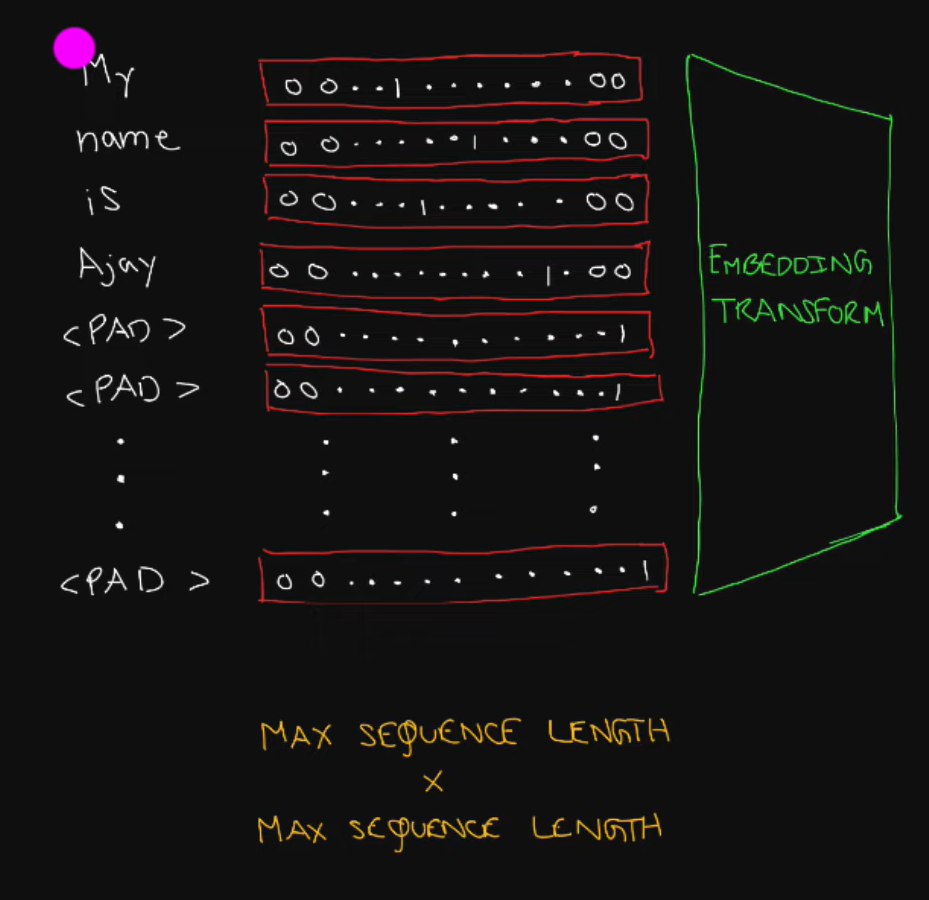

<PAD>代表斷句，在輸入前需要自行加上

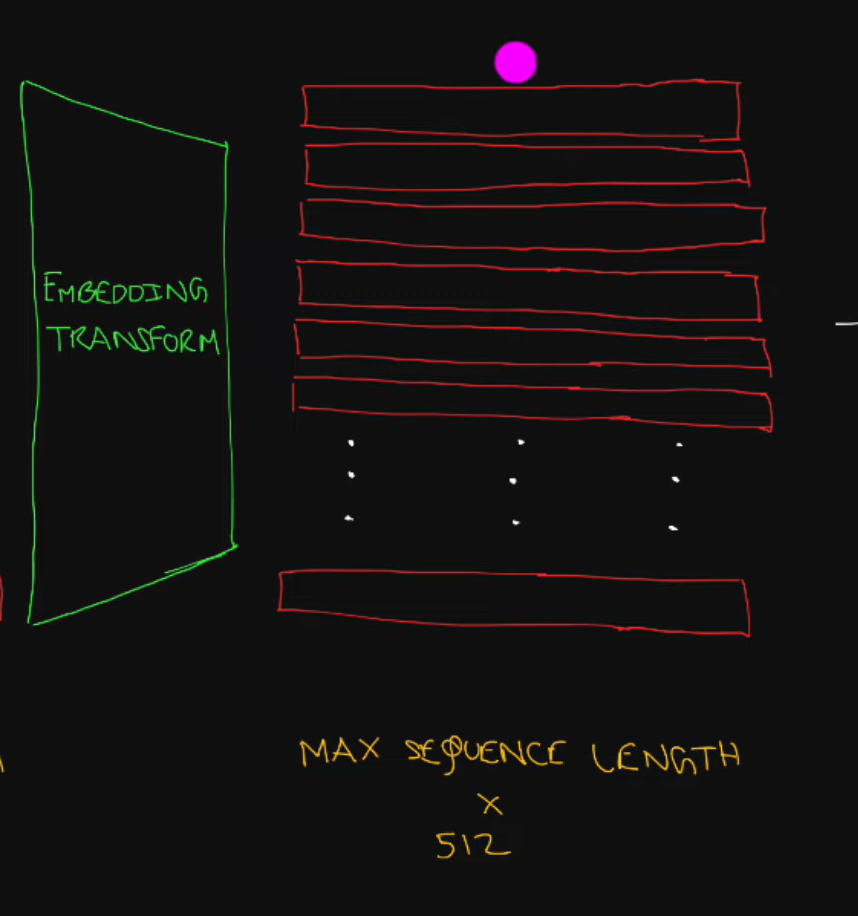

512可以自行定義

In [2]:
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Dense,Dropout

# Embedding

In [178]:
'''
    For a given sentence,create an embedding
    不需要自行轉one-hot向量 透過embedding layer 做詞嵌入向量即可
    '''
class SequenceEmbedding(tf.keras.layers.Layer):
    
    def __init__(self,max_sequence_length,d_model,lan_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(lan_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = Embedding(d_model,input_shape=(self.vocab_size,))
        self.lan_to_index = lan_to_index
        self.position_encoder =PositionalEncoding(d_model,max_sequence_length)
        self.dropout = Dropout(0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN
        
    def batch_tokenize(self,batch,start_token,end_token):
        emp = ['_']* max_sequence_length 
        t = 0

        for n in batch:

            t += n[1]

            indx = int(t//delta)-1
            if indx >= self.max_sequence_length:
                continue
    #         print(indx)
            emp[indx] = str(n[0])

        for e in range(len(emp)):
            emp[e] = self.lan_to_index[emp[e]]
    #     print(emp)
        if start_token:
            emp.insert(0,self.lan_to_index[self.START_TOKEN])
        if end_token:
            emp.append(self.lan_to_index[self.END_TOKEN])
        return tenemp
    
    def call(self,x,start_token,end_token): # sentence
        x = self.batch_tokenize(x,start_token,end_token)
        x = self.embedding(x)
        pos = self.position_encoder()
        x = self.dropout(x+pos)
        return x
                          
        

In [9]:
# Define the Parameter
d_model = 512
num_heads = 8
drop_prob = 0.1 # for Dropout
batch_size= 30
max_sequence_length = 128 # 200 for word, 128 for notes
ffn_hidden = 2048 # for Feed Forward Network
num_layers = 5 # number of Encoder & Decoder blocks
# vocab_size = 128 (word class num)

# Encoder Layer

In [179]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob):
        
        super(EncoderLayer,self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model,num_heads=num_heads)
        self.norm1 = LayerNorm(parameter_shape=[d_model])
        self.dropout1 = Dropout(drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model,hidden=ffn_hidden,drop_prob=drop_prob )
        self.norm2 = LayerNorm(parameter_shape=[d_model])
        self.dropout2 = Dropout(drop_prob)
    
    def call(self,x,mask):
        residual_x = x # 30 x 128 x 512
        x = self.attention(x,mask=mask) # 30 x 128 x 512
        x = self.dropout1(x) # 30 x 128 x 512
        x = self.norm1(x+residual_x) # 30 x 128 x 512
        residual_x = x # 30 x 128 x 512
        x = self.ffn(x) # 30 x 128 x 512
        x = self.dropout2(x) # 30 x 128 x 512
        x= self.norm2(x+residual_x) # 30 x 128 x 512
        
        return x

# Encoder

In [180]:
# 建Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob,num_layers,
                 max_sequence_length,lan_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN):
        super().__init__()
        self.sequence_embedding = SqeunceEmbedding(max_sequence_length,d_model,lan_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
        self.layers = Sequential()
        for _ in range(num_layers):
            self.layers.add(EncoderLayer(d_model,ffn_hidden,num_heads,drop_prob))
#         [EncoderLayer(d_model,ffn_hidden,num_heads,drop_prob) 
#                                    for _ in range(num_layers)]
        
    def call(self,x,mask,start_token,end_token):
        x = self.sequence_embedding(x,start_token,end_token)
        x = self.layers(x,mask)
        return x

In [414]:
encoder = Encoder(d_model,ffn_hidden,num_heads,drop_prob,num_layers)

# Decoder Layer

In [181]:
class DecoderLayer(tf.keras.layers.Layer):
    
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob):
        
        super(DecoderLayer,self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model,num_heads=num_heads)
        self.norm1 = LayerNorm(parameter_shape=[d_model])
        self.dropout1 = Dropout(drop_prob)
        # cross attention here
        self.encoder_decoder_attention =  MultiHeadCrossAttention(d_model=d_model,num_heads=num_heads)
        self.norm2 = LayerNorm(parameter_shape=[d_model])
        self.dropout2 = Dropout(drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model,hidden=ffn_hidden,drop_prob=drop_prob)
        self.norm3 = LayerNorm(parameter_shape=[d_model])
        self.dropout3 = Dropout(drop_prob)
    
    def call(self,x,y,mask=None,cross_mask=None):
        _y = y # for residual # 30 x 128 x 512
        y = self.self_attention(y,mask=mask) # 30 x 128 x 512
        y = self.dropout1(y) # 30 x 128 x 512
        y = self.norm1(y+_y) # 30 x 128 x 512
        
        _y = y # for residual # 30 x 128 x 512
        # Cross attention
        y = self.encoder_decoder_attention(x,y,mask=cross_mask)
        y = self.droptout2(y)
        y = self.norm2(y+_y)
        
        return y

# SequentialDecoder

In [182]:
# 一般的Sequential 只能輸入一個參數, 由於需要輸入多個參數,所以才自定義 Sequential
class SequentialDecoder(Sequential):
    def call(self,*inputs):
        x,y,mask,cross_mask = inputs
        for layer in self.layers:
            y = layer(x,y,mask,cross_mask) # 30 x 128 x 512
        
        return y

# Decoder

In [183]:
class Decoder(tf.keras.layers.Layer):
    
    def _init__(self,d_model,ffn_hidden,num_heads,drop_prob,num_layers,
               max_sequence_length,lan_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN):
        
        super().__init__()
        self.sequence_embedding = Sequence_Embedding(max_sequence_length,d_model,lan_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
        self.layers  = SequentialDecoder()
        for _ in range(num_layers):
            self.layers.add(DecoderLayer(d_model,ffn_hidden,num_heads,drop_prob))
        
    def call(self,x,y,mask,cross_mask,start_token,end_token):
        # x: 30 x 128 x 512
        # y: 30 x 128 x 512
        # mask: 128 x 128
        y = self.sequence_embedding(y,start_token,end_token)
        y = self.layers(x,y,mask,cross_mask)
        return y

In [418]:
x = tf.random.normal([batch_size,max_sequence_length,d_model]) # 原始sequence(input) positional encoded
y = tf.random.normal([batch_size,max_sequence_length,d_model]) # 翻譯sequence(output,for docoder) positional encoded
# build mask
mask = tf.fill([max_sequence_length,max_sequence_length],float('-inf'))
mask = tf.experimental.numpy.triu(mask,k=1)

decoder = Decoder(d_model,ffn_hidden,num_heads,drop_prob,num_layers)

In [ ]:
out = decoder(x,y,mask)

# Transformer

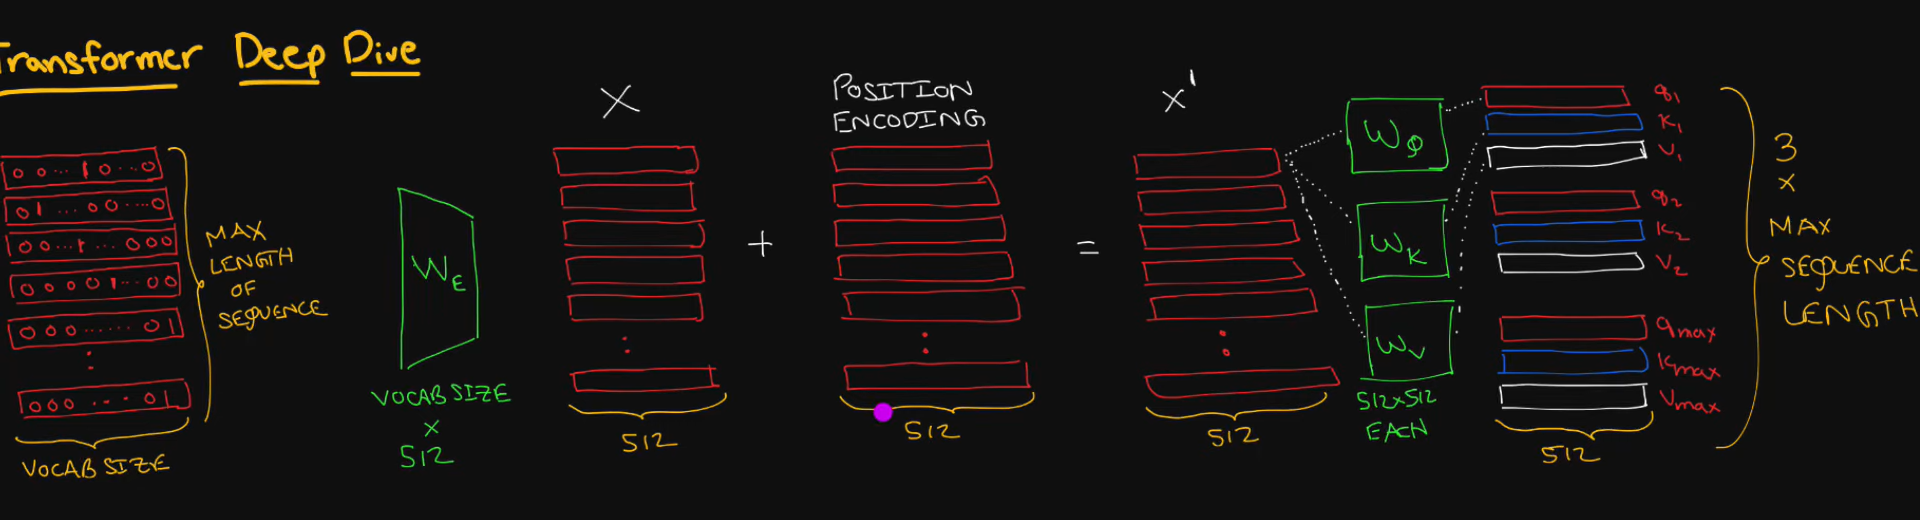

In [184]:
class Transformer(tf.keras.layers.Layer):
    
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob,num_layers,
                max_sequence_length,kn_vocab_size,origin_to_index,transform_to_index,
                 START_TOKEN,END_TOKEN,PADDING_TOKEN):
        '''
        以下參數是 Embedding sentences 使用的, 之後在做音符處理時可以使用到
        origin_to_index,transform_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN
        在資料來源中, 這些參數會傳入Encoder 跟Decoder做Embedding,
        因此使用時需要傳入這兩者
        '''
        super().__init__()
        self.encoder = Encoder(d_model,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,origin_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
        self.decoder = Decoder(d_model,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,transform_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
        self.linear = Dense(kn_vocab_size,input_shape=(d_model,))
#         self.device = 

    def call(self,x,y,encoder_mask=None,decoder_mask=None,cross_mask=None,
            enc_start_token = False,enc_end_token=False,
             dec_start_token=False, # We should make this true
             dec_end_token=False): # x, y are batch of sentence
        
        x = self.encoder(x,encoder__mask,start_token=enc_start_token,end_token=enc_end_token)
        out = self.decoder(x,y,decoder_mask,cross_mask,start_token=dec_start_token,end_token=dec_end_token)
        out = self.linear(out)
        return out